# Demostración Efecto Punta

Writen by: Oscar Reula (oreula@gmail.com)

This code is writen in Fenics/Python, it is used to demostrate the spike effect in a conductor. At the moment is 2-dimensional. This restriction is mainly due to have a code that can run in home computers in very short time. 

We first call all the libraries needed. You can find a very good tutorial for Fenics at: http://launchpad.net/fenics-book/trunk/final/+download/fenics-book-2011-10-27-final.pdf

In [1]:
%matplotlib inline

"""
FEniCS program to compute the capacity matrix of several conductors enclosed in a box
"""

#from __future__ import print_function
#from fenics import *
#from mshr import *
import numpy as np
from math import asin
#import matplotlib as mpl
import matplotlib.pyplot as mpl

9245


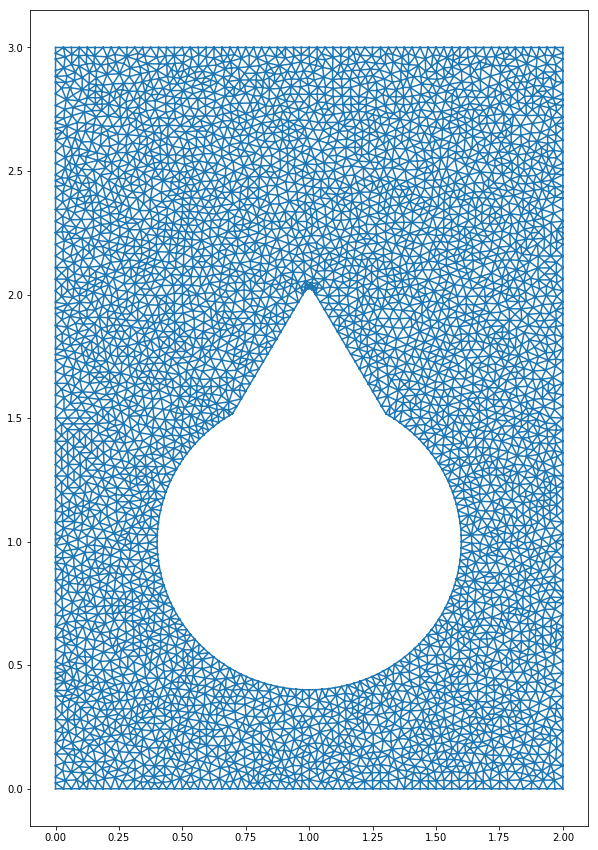

In [3]:
from dolfin import *
from mshr import *
from pylab import show, triplot

diff = False
#diff = True
#cont = False
cont = True
circulo_sup = False

base_line = 1.0
side_x = 2.
side_y = 3.
base = 1.2 # must be smaller than side_x - base_line - high
high = 1.0
l = 0.05
L = sqrt(base*base/4. + high*high)
N = 8

# to adjust the boundary to have continuous first derivative (it does not work well because how the mesh is build)
if diff:
    radio = base / 2. / L * l
    t = base / 2. / L * radio
    s = radio * high / L

if cont: 
    radio = base / 2. / high * l
    s = radio
    t = 0.
    
if circulo_sup:

    square =  Rectangle(Point(0., 0.), Point(side_x,side_y))

    triangle_vertices = [
        Point((side_x + base)/2., base_line),
        Point(side_x/2. + s, base_line + high - l + t),
        Point(side_x/2. - s, base_line + high - l + t),
        Point((side_x - base)/2., base_line)]
    triangle = Polygon(triangle_vertices)

    semi_circulo_superior = Circle(Point(side_x/2., high + base_line - l), radio)
    
    semi_circulo_inferior = Circle(Point(side_x/2., base_line ), base/2.)

    domain = square - triangle - semi_circulo_superior - semi_circulo_inferior
    
    
else:
    
    
    triangle_vertices = [
        Point((side_x - base)/2., base_line),
        Point((side_x + base)/2., base_line)]
    
    for i in range(0,N+1):
        s = i*l/N
        triangle_vertices.append(Point((side_x + l)/2. - s, base_line + high + 2.*s*(l-s)/l))
        
    
    poligono = Polygon(triangle_vertices)
    
    square =  Rectangle(Point(0., 0.), Point(side_x,side_y))
    
    semi_circulo_inferior = Circle(Point(side_x/2., base_line ), base/2.)

    domain = square - poligono - semi_circulo_inferior
    
    
mesh = generate_mesh(domain,64)
coords = mesh.coordinates()
mpl.figure(figsize=(10,15))
triplot(coords[:,0], coords[:,1], triangles=mesh.cells())
print(mesh.num_cells())
show()

We now create several objects and include them in the first, which is a square, to create a **domain**. After that we generate a mesh for that domain. The number in it is the number of triangulations. Could be from 32 to 254, say, for a short calculation.

We generate the function space, this are polynomials of degree 1. The first is for the potential, a scalar, the second for the electric field.

In [4]:
V = FunctionSpace(mesh, 'CG', 2)
#V = FunctionSpace(mesh, 'P', 1)
#W = VectorFunctionSpace(mesh, 'P', 1)

Here we give several options: first is to test the code with a "known solution", $u_D=1+x^2+2y^2$, with source $f=-6$. The boundary data (Dirichlet) is given so that it is satisfied. In this option you would get information about how good the solution is, since it prints the $L^2$ and maximun norm of the difference between the exact and numerical solution.
You can change the *exact solution* and acordingly its *source* as you like.

The other options put to zero the potencials of one of the bodies and to 1 that of the other, so running it twice, each with one of the *capacity_* options True generate the whole capacity matrix. One should check that it is **symmetric**.

In [5]:
test1 = False
spike = True

if test1:
    u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

Next we define the boundaries, they are needed to impose the boundary conditions and then to compute the charges. 

In [7]:
# Define boundary condition


tol = 1.E-14

#boundary_markers = FacetFunction('size_t', mesh)
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
class outer_0(SubDomain):
    def inside(self, x, on_boundary):
        return  near(x[0], 0, tol) or near(x[0],side_x, tol) \
            or near(x[1],0, tol) or near(x[1],side_y, tol)
outer0 = outer_0()
outer0.mark(boundary_markers, 0)
                                 
class triangle_1(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and x[0]>=(side_x - base)/2.-tol and x[0]<(side_x + base)/2.+tol and x[1]> base_line - base/2. - tol and x[1]< base_line + base/2. + high +tol
triangle1 = triangle_1()
triangle1.mark(boundary_markers,1)

# the boundary surface elements 
#ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
             
if spike:
    u_outer = Expression('0', degree=2)
    u_triangle = Expression('1', degree=2)
    bc_out = DirichletBC(V, u_outer, outer0)
    bc_ls = DirichletBC(V, u_triangle, triangle1)

if test1:
    bc_out = DirichletBC(V, u_D, outer0)
    bc_ls = DirichletBC(V, u_D, triantle1)

bcs = [bc_out, bc_ls]

Next we define the problem (in the weak sense) we want to solve. First the function spaces, then the sources according to the problem and then the matrices and sources to solve a problem of the type $A x = b$. Recall the weak problem is: 
\begin{equation}
\int_{\Omega} \nabla u \cdot \nabla v \; dV = \int_{\Omega} f v \; dV \;\;\;\; \forall \;v \in \; V
\end{equation}

In [8]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

if spike: 
    f = Constant(-0.0)

if test1:
    f = Constant(-6.0)
#f = Expression('exp(x[0]*x[0] + x[1]*x[1])', degree=2)
    
a = dot(grad(u), grad(v))*dx
L = f*v*dx

We call then a solver with the correct boundary conditions. It doesn't seems to be working. If tolerance is big, it does not refine, if smaller the kernel dies.

In [9]:
# Compute solution
u = Function(V)
M = u*dx()
tol = 1.E-5
#solve(a == L, u, bcs)
problem = LinearVariationalProblem(a, L, u, bcs)
solver = AdaptiveLinearVariationalSolver(problem, M)
solver.parameters["error_control"]["dual_variational_solver"]["linear_solver"] = "cg"
solver.parameters["error_control"]["dual_variational_solver"]["symmetric"] = True
solver.parameters["max_iterations"] = 7
solver.solve(tol)

solver.summary()

We then plot the solution on screen and save to files the solution in a special format to visualize with Paraview or VisIt.

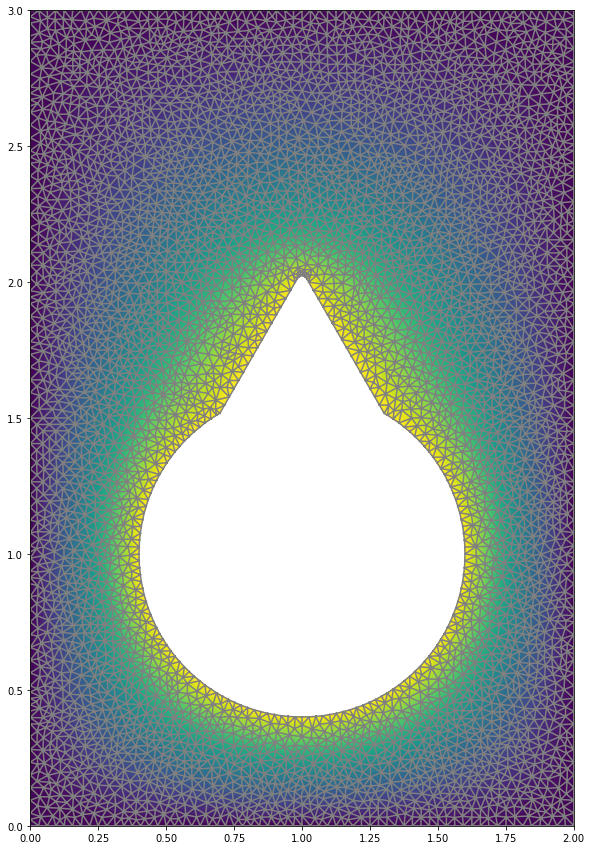

In [10]:
# Plot solution and mesh
mpl.figure(figsize=(10,15))
plot(u.leaf_node())
plot(mesh)

# Save solution to file in VTK format

if spike:
    vtkfile_phi_init = File('Efecto-Punta/potential_01_init_mesh.pvd')
    vtkfile_e_init = File('Efecto-Punta/field_01_init_mesh.pvd')
    vtkfile_phi = File('Efecto-Punta/potential_01_final_mesh.pvd')
    vtkfile_e = File('Efecto-Punta/field_01_final_mesh.pvd')

if test1 :
    vtkfile_phi_init = File('Efecto-Punta/potential_test_init_mesh.pvd')
    vtkfile_e_init = File('Efecto-Punta/field_test_init_mesh.pvd')
    vtkfile_phi = File('Efecto-Punta/potential_test_final_mesh.pvd')
    vtkfile_e = File('Efecto-Punta/field_test_final_mesh.pvd')

    
#vtkfile_phi << u


vtkfile_phi_init << u.root_node()
vtkfile_phi << u.leaf_node()

We can also compute the electric field and save it in a file.

In [15]:

# Compute de electric field
#W = VectorFunctionSpace(mesh.leaf_node(), 'CG', 2) 
W = VectorFunctionSpace(mesh, 'CG', 2)   # Aqui cambié lo anterior
#e = project(-grad(u.leaf_node()),W)
e = project(-grad(u),W)       # Aqui cambié lo anterior

vtkfile_e << e

Now compute the maximum value for the electric field:

In [18]:
e_x, e_y = e.split(deepcopy=True)
#e_max = sqrt(np.max(np.abs(e_x.compute_vertex_values(mesh.leaf_node())*e_x.compute_vertex_values(mesh.leaf_node()) + e_y.compute_vertex_values(mesh.leaf_node())*e_y.compute_vertex_values(mesh.leaf_node()))))
e_max = sqrt(np.max(np.abs(e_x.compute_vertex_values(mesh)*e_x.compute_vertex_values(mesh) + e_y.compute_vertex_values(mesh)*e_y.compute_vertex_values(mesh))))

print(e_max)
print(asin(base/2./high))


6.477031271648074
0.6435011087932844


Recall that the charge is defined as: 
\begin{equation}
Q_i = \int_{\partial \Omega_i} \sigma dS =  4\pi\int_{\partial \Omega_i} E \cdot \; dS
\end{equation}
And the **capacity matrix** by the relation: 

\begin{equation}
Q_i = C_{ij}V^j
\end{equation}

In [19]:
# Compute the charge integral
# the boundary surface elements 
#ds = Measure('ds', domain=mesh.leaf_node(), subdomain_data=boundary_markers) #esta no funciona
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers) # esta funciona
#n = FacetNormal(mesh.leaf_node()) # esta no funciona
#n = FacetNormal(mesh.root_node()) # esta funciona
n = FacetNormal(mesh) # esta funciona 

#square_flux = -dot(grad(u),n)*ds(1)
#square_coarse = dot(e_coarse,n)*ds(1)
square_flux = dot(e,n)*ds(1)
Q_square = assemble(square_flux)


print('Charge_square = {0:.4f}' .format(Q_square))

Charge_square = -10.2427


This is to check the code and the boundary conditions, **ALWAYS** run it first! Put above test1=*True*, and both capacities to *False*


In [20]:
if test1:
# Compute error in L2 norm
    error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
    vertex_values_u_D = u_D.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
    print('error_L2  =', error_L2)
    print('error_max =', error_max)

# Hold plot
#interactive()

In [21]:
e_m_3=[6.1479,6.3376,6.2764,6.2134,5.9662,5.7356] # l=0.1

In [22]:
e_m_5=[7.26,7.66,7.36,7.548,6.61,6.34] #_5 significa 5 iteraciones, l=0.1

In [23]:
e_m_5_05=[9.42,10.14,9.538,9.138,8.12,7.81]  # l=0.05

In [24]:
e_m_7_05=[10.44,10.14,9.538,9.138,8.124,]

In [25]:
alpha=[1.4706,1.3694,1.2661,1.1592,1.04719,0.9272]

In [26]:
asin(cos(0.9272))

0.6435963267948965

In [27]:
theta=[0.10,0.20,0.304,0.411,0.523,0.64]                # theta = asin(cos(alpha))

In [28]:
bas=[0.2,0.4,0.6,0.8,1.0,1.2]

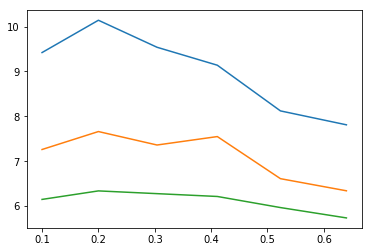

In [29]:
mpl.plot(theta,e_m_5_05,theta,e_m_5, theta, e_m_3)
mpl.show()